# Towards scalabe intertidal vegetation mapping using Sentinel-2 

## Intro

In this notebook, we explore the potential of the Copernicus Data Space Ecosistem (CDSE), together with [extensive field data collected by the Seagrass Ecology Group](https://coastal-ai.github.io/GEAM_GEODATABASE/) of the Spanish Institute of Oceanography (IEO-CSIC)  to map intertidal vegetation in Villaviciosa, a coastal protected area in the north coast of Spain.

## Fetching S2 L2A zarr data

### Libraries

In [1]:
import os
import dask
import xarray as xr
from pyproj import Transformer
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pystac_client
from pystac_client import CollectionSearch
from matplotlib.gridspec import GridSpec
import geopandas as gpd
from shapely.geometry import box
import folium
import rioxarray
import rasterio.transform
from rasterio.features import geometry_mask

### Test region

In [5]:
bbox = [-5.44,43.48,-5.36,43.54]
crs_wgs84 = "EPSG:4326"
crs_utm = "EPSG:32630"
# Reproject bbox from WGS84 to UTM using pyproj.Transformer
transformer = Transformer.from_crs(crs_wgs84, crs_utm, always_xy=True)
min_lon, min_lat, max_lon, max_lat = bbox
min_x, min_y = transformer.transform(min_lon, min_lat)
max_x, max_y = transformer.transform(max_lon, max_lat)
bbox_utm = (min_x, min_y, max_x, max_y)

time_range = ["2025-06-01", None]
cloud_cover_max = 30

### PLOT REGION

# Center of the bbox
center_lat = (bbox[1] + bbox[3]) / 2
center_lon = (bbox[0] + bbox[2]) / 2

# Create folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="CartoDB positron")

# Add bbox as a rectangle
folium.Rectangle(
    bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
    color="red",
    fill=False,
    weight=2,
    tooltip="AOI"
).add_to(m)

m

In [6]:
print (bbox_utm)


(302671.48196904117, 4817012.335989605, 309330.5538313079, 4823489.5372470645)


### pystac API search

In [3]:
catalog = pystac_client.Client.open("https://stac.core.eopf.eodc.eu")
# Search with cloud cover filter
items = list(
    catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=bbox,
        datetime=time_range,
        #query={"eo:cloud_cover": {"lt": cloud_cover_max}}, 
    ).items()
)
print(len(items))
for item in items:
    print(f"{item.id} / {item.properties['proj:code']}")


/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T30TUP_20251104T134759' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T29TQJ_20251104T134759' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T30TUP_20251101T151319' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T29TQJ_20251101T151319' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251101T111119_N0511_R137_T30TUP_20251101T

140
S2B_MSIL2A_20260202T112159_N0511_R037_T30TUP_20260202T151511 / EPSG:32630
S2B_MSIL2A_20260202T112159_N0511_R037_T29TQJ_20260202T151511 / EPSG:32629
S2B_MSIL2A_20260130T111209_N0511_R137_T30TUP_20260130T150430 / EPSG:32630
S2B_MSIL2A_20260130T111209_N0511_R137_T29TQJ_20260130T150430 / EPSG:32629
S2C_MSIL2A_20260128T112321_N0511_R037_T30TUP_20260128T151411 / EPSG:32630
S2C_MSIL2A_20260128T112321_N0511_R037_T29TQJ_20260128T151411 / EPSG:32629
S2C_MSIL2A_20260125T111341_N0511_R137_T30TUP_20260125T145411 / EPSG:32630
S2C_MSIL2A_20260125T111341_N0511_R137_T29TQJ_20260125T145411 / EPSG:32629
S2B_MSIL2A_20260123T112249_N0511_R037_T30TUP_20260123T133836 / EPSG:32630
S2B_MSIL2A_20260123T112249_N0511_R037_T29TQJ_20260123T133836 / EPSG:32629
S2C_MSIL2A_20260118T112411_N0511_R037_T30TUP_20260118T130309 / EPSG:32630
S2C_MSIL2A_20260118T112411_N0511_R037_T29TQJ_20260118T130309 / EPSG:32629
S2C_MSIL2A_20260115T111421_N0511_R137_T30TUP_20260115T124410 / EPSG:32630
S2C_MSIL2A_20260115T111421_N0511_R

In [14]:
# Print full content and hierarchy of first item
item = items[0]

print("=" * 80)
print("ITEM OBJECT STRUCTURE")
print("=" * 80)

# Basic info
print(f"\nItem ID: {item.id}")
print(f"Item Type: {type(item)}")
print(f"\nProperties:")
for key, value in item.properties.items():
    print(f"  {key}: {value}")

print(f"\n\nAssets (count: {len(item.assets)}):")
for asset_key, asset in item.assets.items():
    print(f"\n  Asset: {asset_key}")
    print(f"    Type: {type(asset)}")
    print(f"    Title: {asset.title if hasattr(asset, 'title') else 'N/A'}")
    print(f"    Media Type: {asset.media_type if hasattr(asset, 'media_type') else 'N/A'}")
    print(f"    Href: {asset.href}")
    if hasattr(asset, 'properties') and asset.properties:
        print(f"    Properties: {asset.properties}")

print(f"\n\nLinks (count: {len(item.links)}):")
for i, link in enumerate(item.links[:5]):  # Show first 5
    print(f"  Link {i}: rel={link.rel}, href={link.href[:80]}...")

print(f"\n\nExtent:")
print(f"  Spatial: {item.geometry if hasattr(item, 'geometry') else 'N/A'}")
print(f"  Temporal: {item.datetime if hasattr(item, 'datetime') else 'N/A'}")

print(f"\n\nAll attributes:")
print(f"  {dir(item)}")

ITEM OBJECT STRUCTURE

Item ID: S2B_MSIL2A_20260202T112159_N0511_R037_T30TUP_20260202T151511
Item Type: <class 'pystac.item.Item'>

Properties:
  gsd: 10.0
  created: 2026-02-02T18:57:11.579540Z
  mission: Sentinel-2
  sci:doi: 10.5270/S2_-znk9xsj
  updated: 2026-02-02T18:57:11.579540Z
  datetime: 2026-02-02T11:21:59.024000Z
  platform: sentinel-2b
  grid:code: MGRS-30TUP
  proj:bbox: [-5.504071407096211, 43.23826255332707, -4.431387430565958, 44.24303155425363]
  proj:code: EPSG:32630
  providers: [{'url': 'https://commission.europa.eu/', 'name': 'European Commission', 'roles': ['licensor']}, {'url': 'https://sentinel.esa.int/web/sentinel/missions/sentinel-2', 'name': 'ESA', 'roles': ['producer', 'processor']}, {'url': 'https://zarr.eopf.copernicus.eu/', 'name': 'EOPF Sentinel Zarr Samples Service', 'roles': ['host', 'processor']}]
  published: 2026-02-02T18:57:11.579540Z
  deprecated: False
  instruments: ['msi']
  end_datetime: 2026-02-02T11:21:59.024000Z
  product:type: S02MSIL2A
 

### Load into xarray

In [4]:
import xarray as xr
from pyproj import Transformer

datasets, included, skipped, crs_list = [], [], [], []

for item in items:
    url = item.assets["product"].href

    # --- Try to open dataset ---
    try:
        ds = xr.open_dataset(url, engine="eopf-zarr", chunks={})
    except Exception as e:
        print(f"\n-{e}")
        skipped.append(url)
        continue

    # --- Get CRS ---
    crs = ds.rio.crs
    print(f"\n-{url.split('/')[-1]}")
    print(f"   URL: {url}")
    print(f"   CRS: {crs}")

    if crs is None:
        print("   No CRS found, skipping")
        skipped.append(url)
        continue

    # --- Reproject WGS84 bbox to dataset CRS ---
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    minx, miny = transformer.transform(bbox[0], bbox[1])
    maxx, maxy = transformer.transform(bbox[2], bbox[3])

    # --- Handle Y axis direction ---
    y_slice = slice(maxy, miny) if ds.y[0] > ds.y[-1] else slice(miny, maxy)

    # --- Clip ---
    ds_clipped = ds.sel(x=slice(minx, maxx), y=y_slice)

    if ds_clipped.sizes["x"] == 0 or ds_clipped.sizes["y"] == 0:
        print("   No overlap with bbox after reprojection")
        skipped.append(url)
        continue

    print(f"   Clipped size: {dict(ds_clipped.sizes)}")

    # --- Store dataset ---
    datasets.append(ds_clipped)
    included.append(url)
    crs_list.append(crs)

print(f"\n✓ Included: {len(included)} | ✗ Skipped: {len(skipped)}")


-S2B_MSIL2A_20260202T112159_N0511_R037_T30TUP_20260202T151511.zarr
   URL: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202602-s02msil2a-eu/02/products/cpm_v262/S2B_MSIL2A_20260202T112159_N0511_R037_T30TUP_20260202T151511.zarr
   CRS: EPSG:32630
   Clipped size: {'x': 666, 'y': 648}

-S2B_MSIL2A_20260202T112159_N0511_R037_T29TQJ_20260202T151511.zarr
   URL: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202602-s02msil2a-eu/02/products/cpm_v262/S2B_MSIL2A_20260202T112159_N0511_R037_T29TQJ_20260202T151511.zarr
   CRS: EPSG:32629
   Clipped size: {'x': 618, 'y': 694}

-S2B_MSIL2A_20260130T111209_N0511_R137_T30TUP_20260130T150430.zarr
   URL: https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202601-s02msil2a-eu/30/products/cpm_v262/S2B_MSIL2A_20260130T111209_N0511_R137_T30TUP_20260130T150430.zarr
   CRS: EPSG:32630
   Clipped size: {'x': 666, 'y': 648}

-S2B_MSIL2A_20260130T111209_N0511_R137_T29TQJ_20260130T150430.zarr
   URL: https://objects.eodc.

## Intertidal zone

### Water frequencies

Water frequency map saved: outputs/water_frequency.tif


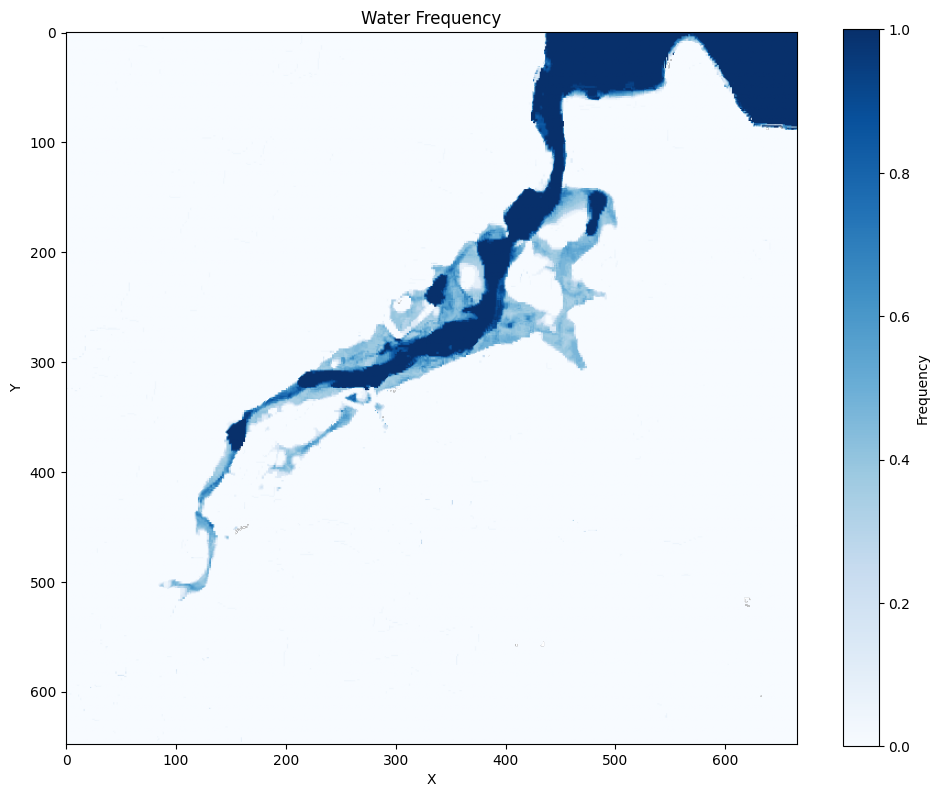

In [8]:
import numpy as np
import rasterio
import rioxarray

# -----------------------------
# PARAMETERS
# -----------------------------
# Pick a reference dataset for alignment
ref_ds = datasets[0]['scl']  # lowercase 'scl'

# Reference CRS, transform, and shape
target_crs = ref_ds.rio.crs
ny, nx = ref_ds.sizes['y'], ref_ds.sizes['x']

# Initialize accumulators
water_count = np.zeros((ny, nx), dtype=int)
obs_count = np.zeros((ny, nx), dtype=int)

# -----------------------------
# LOOP OVER DATASETS
# -----------------------------
for ds in datasets:
    if 'scl' not in ds:
        continue

    scl = ds['scl']

    # Flip Y if descending
    if scl.y[0] > scl.y[-1]:
        scl = scl.isel(y=slice(None, None, -1))

    # Ensure CRS is set
    if scl.rio.crs is None:
        scl = scl.rio.write_crs(target_crs, inplace=True)

    # Reproject to reference dataset grid
    scl_rp = scl.rio.reproject_match(
        ref_ds,
        resampling=rasterio.enums.Resampling.nearest
    )

    # Convert to numpy
    scl_vals = scl_rp.values

    # Valid pixels and water mask
    valid = np.isin(scl_vals, [4, 5, 6])  # only clear land or water
    water = (scl_vals == 6)

    # Accumulate counts
    obs_count[valid] += 1
    water_count[valid] += water[valid]

# -----------------------------
# COMPUTE WATER FREQUENCY
# -----------------------------
freq = np.full_like(water_count, fill_value=np.nan, dtype=float)
mask = obs_count > 0
freq[mask] = water_count[mask] / obs_count[mask]

# -----------------------------
# SAVE AS GEO-TIFF
# -----------------------------
out_path = "outputs/water_frequency.tif"

with rasterio.open(
    out_path,
    'w',
    driver='GTiff',
    height=ny,
    width=nx,
    count=1,
    dtype='float32',
    crs=target_crs,
    transform=ref_ds.rio.transform(),
    compress='LZW'
) as dst:
    dst.write(freq.astype('float32'), 1)

print(f"Water frequency map saved: {out_path}")

# Plot water frequency
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(freq, cmap='Blues', vmin=0, vmax=1)
ax.set_title('Water Frequency')
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(im, ax=ax, label='Frequency')
plt.tight_layout()
plt.show()

### Intertidal mask

Intertidal mask raster saved
Intertidal vector saved: outputs/intertidal_mask.gpkg


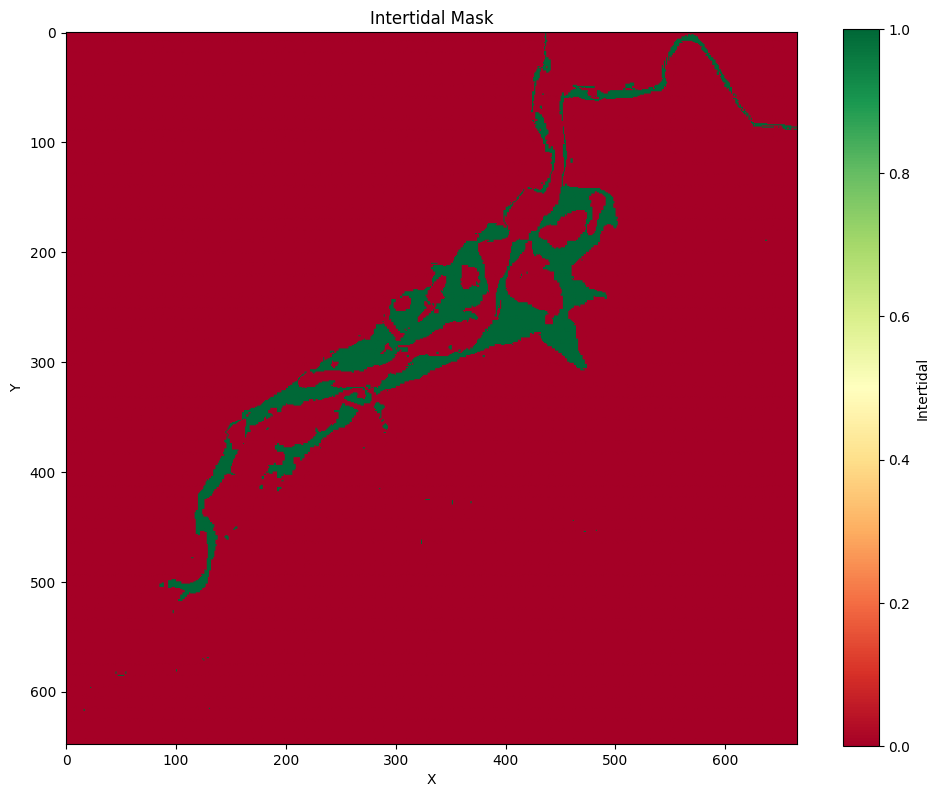

In [9]:
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape

# -----------------------------
# LOAD WATER FREQUENCY RASTER
# -----------------------------
with rasterio.open("outputs/water_frequency.tif") as src:
    freq = src.read(1)
    transform = src.transform
    crs = src.crs
    meta = src.meta.copy()

# -----------------------------
# CREATE INTERTIDAL MASK
# -----------------------------
intertidal_mask = np.zeros_like(freq, dtype=np.uint8)
intertidal_mask[(freq >= 0.1) & (freq <= 0.95)] = 1

# -----------------------------
# SAVE MASK AS GEOTIFF
# -----------------------------
meta.update(dtype=rasterio.uint8, count=1, compress="LZW")

with rasterio.open("outputs/intertidal_mask.tif", "w", **meta) as dst:
    dst.write(intertidal_mask, 1)

print("Intertidal mask raster saved")

# -----------------------------
# RASTER → VECTOR POLYGONS
# -----------------------------
geoms = []

for geom, value in shapes(intertidal_mask, transform=transform):
    if value == 1:
        geoms.append(shape(geom))

gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs)

# -----------------------------
# DISSOLVE INTO SINGLE MULTIPART POLYGON
# -----------------------------
gdf = gdf.dissolve()        # dissolve all touching pixels
gdf = gdf.reset_index(drop=True)

# -----------------------------
# SAVE VECTOR FILE
# -----------------------------
gdf.to_file("outputs/intertidal_mask.gpkg", driver="GPKG")

print("Intertidal vector saved: outputs/intertidal_mask.gpkg")

# Plot intertidal mask
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(intertidal_mask, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_title('Intertidal Mask')
ax.set_xlabel('X')
ax.set_ylabel('Y')
cbar = plt.colorbar(im, ax=ax, label='Intertidal')
plt.tight_layout()
plt.show()

### Plot

In [10]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
import folium
from matplotlib import cm

# -----------------------------
# FILES
# -----------------------------
raster_path = "outputs/water_frequency.tif"
vector_path = "outputs/intertidal_mask.gpkg"
output_html = "outputs/water_frequency_map.html"

# -----------------------------
# READ RASTER
# -----------------------------
with rasterio.open(raster_path) as src:
    raster = src.read(1)
    raster_transform = src.transform
    raster_crs = src.crs
    ny, nx = src.height, src.width
    raster_bounds = src.bounds

# -----------------------------
# READ VECTOR AND RASTERIZE TO MATCH RASTER
# -----------------------------
gdf = gpd.read_file(vector_path).to_crs(raster_crs)

# Rasterize vector mask (1 = intertidal, 0 = elsewhere)
mask_raster = rasterize(
    [(geom, 1) for geom in gdf.geometry],
    out_shape=(ny, nx),
    transform=raster_transform,
    fill=0,
    dtype=np.uint8
)

# -----------------------------
# NORMALIZE AND COLOR RASTER
# -----------------------------
raster_norm = (raster - np.nanmin(raster)) / (np.nanmax(raster) - np.nanmin(raster))
rgba_raster = (cm.Blues(raster_norm) * 255).astype(np.uint8)

# -----------------------------
# TRANSFORM BOUNDS TO EPSG:4326 FOR FOLIUM
# -----------------------------
from rasterio.warp import transform_bounds
left, bottom, right, top = transform_bounds(raster_crs, "EPSG:4326", *raster_bounds)

# -----------------------------
# CREATE FOLIUM MAP
# -----------------------------
m = folium.Map(location=[(bottom + top)/2, (left + right)/2], zoom_start=13, tiles="CartoDB positron")

# Add raster
folium.raster_layers.ImageOverlay(
    image=rgba_raster,
    bounds=[[bottom, left], [top, right]],
    opacity=0.6,
    name="Water Frequency"
).add_to(m)

# Add rasterized intertidal mask
folium.raster_layers.ImageOverlay(
    image=np.stack([mask_raster*255]*3, axis=-1),  # convert to RGB
    bounds=[[bottom, left], [top, right]],
    opacity=0.4,
    name="Intertidal Mask",
).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Save
m.save(output_html)
print(f"Html map saved: {output_html}")

Html map saved: outputs/water_frequency_map.html


### Notes

The xcube-eopf plugin provides a higher-level data cube abstraction, but requires specific metadata that may not always be available in all STAC catalog formats, raising compatibility issues. The **pystac + xarray approach used above is the recommended and most flexible approach** for EOPF Zarr data.

**Why pystac + xarray is preferred:**
- Works reliably with current EOPF STAC catalogs
- Full control over data loading and stacking
- Direct access to all asset metadata
- Easy to debug and customize
- Lightweight (no additional abstraction layer)


In [11]:
from xcube.core.store import new_data_store
from xcube.util.config import load_configs
from xcube.webapi.viewer import Viewer
from xcube_resampling.utils import reproject_bbox

In [12]:
xr.set_options(display_expand_attrs=False)
store = new_data_store("eopf-zarr")
store.list_data_ids()

['sentinel-2-l1c',
 'sentinel-2-l2a',
 'sentinel-3-olci-l1-efr',
 'sentinel-3-olci-l2-lfr',
 'sentinel-3-slstr-l1-rbt',
 'sentinel-3-slstr-l2-lst']

In [16]:
%%time
ds = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox_utm, # bbox in degrees can also be used
    time_range=time_range,
    spatial_res=10, # in that case convert m to degrees: 10 / 111320 
    crs=crs_utm, # and change to EPSG:4326
    variables=["b01", "b02", "b03", "b04", "scl"],
)
ds

/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T30TUP_20251104T134759' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251104T112139_N0511_R037_T29TQJ_20251104T134759' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T30TUP_20251101T151319' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2A_MSIL2A_20251101T112241_N0511_R037_T29TQJ_20251101T151319' is deprecated.
  warnings.warn(
/Users/fer/anaconda3/envs/landscape/lib/python3.13/site-packages/pystac/item.py:481: DeprecatedWarning: The item 'S2B_MSIL2A_20251101T111119_N0511_R137_T30TUP_20251101T

FileNotFoundError: No such file or directory: 'https://objects.eodc.eu:443/e05ab01a9d56408d82ac32d69a5aae2a:202509-s02msil2a-eu/25/products/cpm_v256/S2B_MSIL2A_20250925T112109_N0511_R037_T29TQJ_20250925T151904.zarr'